# Clustering for Transaction Classification

This notebook covers use cases where your data is unlabelled but has features that can be used to cluster them into meaningful categories. The challenge with clustering is making the features that make those clusters stand out human-readable, and that is where we'll look to use GPT-3 to generate meaningful cluster descriptions for us. We can then use these to apply labels to a previously unlabelled dataset.

To feed the model we use embeddings created using the approach displayed in the notebook [Multiclass classification for transactions Notebook](Multiclass_classification_for_transactions.ipynb), applied to the full 359 transactions in the dataset to give us a bigger pool for learning

## Setup

In [1]:
%load_ext autoreload
%autoreload 

In [6]:
import openai
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
import os

openai.api_key = os.getenv("OPENAI_API_KEY")
COMPLETIONS_MODEL = "text-davinci-002"

# This path leads to a file with embeddings created in the notebook linked above
embedding_path = 'data/transactions_with_embeddings_359.csv'

## Clustering

We'll reuse the approach from the [Clustering Notebook](Clustering.ipynb), using K-Means to cluster our dataset using the feature embeddings we created previously. We'll then use the Completions endpoint to generate cluster descriptions for us and judge their effectiveness

In [7]:
embedding_df = pd.read_csv(embedding_path)
embedding_df["babbage_similarity"] = embedding_df.babbage_similarity.apply(eval).apply(np.array)
matrix = np.vstack(embedding_df.babbage_similarity.values)
matrix.shape

(359, 2048)

In [8]:
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
embedding_df["Cluster"] = labels

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

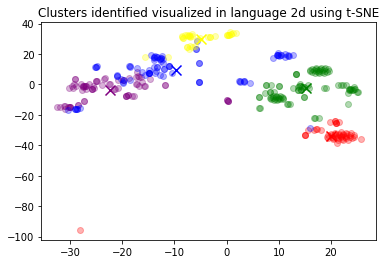

In [9]:
tsne = TSNE(
    n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200
)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue","yellow"]):
    xs = np.array(x)[embedding_df.Cluster == category]
    ys = np.array(y)[embedding_df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")


In [11]:
# We'll read 10 transactions per cluster as we're expecting some variation
transactions_per_cluster = 10

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    transactions = "\n".join(
        embedding_df[embedding_df.Cluster == i]
        .combined.str.replace("Supplier: ", "")
        .str.replace("Description: ", ":  ")
        .str.replace("Value: ", ":  ")
        .sample(transactions_per_cluster, random_state=42)
        .values
    )
    response = openai.Completion.create(
        engine=COMPLETIONS_MODEL,
        # We'll include a prompt to instruct the model what sort of description we're looking for
        prompt=f'''We want to group these transactions into meaningful clusters so we can target the areas we are spending the most money. 
                What do the following transactions have in common?\n\nTransactions:\n"""\n{transactions}\n"""\n\nTheme:''',
        temperature=0,
        max_tokens=100,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response["choices"][0]["text"].replace("\n", ""))

    sample_cluster_rows = embedding_df[embedding_df.Cluster == i].sample(transactions_per_cluster, random_state=42)
    for j in range(transactions_per_cluster):
        print(sample_cluster_rows.Supplier.values[j], end=", ")
        print(sample_cluster_rows.Description.values[j], end="\n   ")
        #print(str(sample_cluster_rows.Value).values[j])

    print("-" * 100)


Cluster 0 Theme:  Literary & Archival ItemsOne possible way to group these transactions into a meaningful cluster is by their theme or purpose. A common theme that appears in most of these transactions is literary and archival items, which suggests that these are payments for acquiring, preserving, or accessing various collections of books, manuscripts, papers, and other materials related to literature and history. This theme could be relevant for a library, a museum, a research institution, or a collector.Some possible indicators of this theme are:-
JISC SERVICES LTD SUBSCRIPTION ACCOUNT, Annual Subscription
   Private Sale, Literary & Archival Items
   ALDL, Oct19-Dec19 charge from Agency for Legal Deposit Libraries
   ALDL, Legal Deposit Services
   Private Sale, Literary & Archival Items
   SONYA LEONARD, Literary and personal papers of Tom Leonard 1961 to 2018
   FROST AND SULLIVAN LTD, Literary & Archival Items
   Cengage Learning (Emea )Ltd, Literary & Archival Items
   Agency f

### Conclusion

We now have five new clusters that we can use to describe our data. Looking at the visualisation some of our clusters have some overlap and we'll need some tuning to get to the right place, but already we can see that GPT-3 has made some effective inferences. In particular, it picked up that items including legal deposits were related to literature archival, which is true but the model was given no clues on. Very cool, and with some tuning we can create a base set of clusters that we can then use with a multiclass classifier to generalise to other transactional datasets we might use.